# Notes

--------------------------------------------

- For Al Bateen weatherfile, peak radiation values are occuring for Diffuse sky dome at odd periods - suggesting issue with reading the sky matrix results file. Following testing against the LB method for loading sky matrices, it was found that these errors were also included in this method and would therefore not be an issue as they're representtative of whats going on in the weatherfile. if a bit odd. Potentially some post processing of the sky matrix to smooth out erroneous values may be worthwhile

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
from climate.core import Weather

# Load weather
epw_file = "./test/weatherfile_London.epw"
weather = Weather(epw_file).read(sky_matrix=True, reuse_matrix=True)

Solar position calculations successful
Psychrometric calculations successful
WEA file created: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_London.wea
Direct and diffuse sky matrices loaded


In [14]:
# weather.mean_radiant_temperature_openfield()
# weather.mean_radiant_temperature_solar_adjusted()

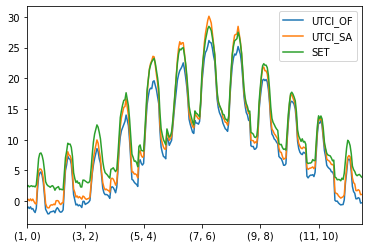

In [66]:
from climate.comfort import universal_thermal_climate_index, standard_effective_temperature

a = weather.dry_bulb_temperature
b = weather.mean_radiant_temperature_of
c = weather.pedestrian_wind_speed
d = weather.relative_humidity
utci_of = pd.Series(universal_thermal_climate_index(a, b, c, d), index=weather.index, name="UTCI_OF")

a = weather.dry_bulb_temperature
b = weather.mean_radiant_temperature_sa
c = weather.pedestrian_wind_speed
d = weather.relative_humidity
utci_sa = pd.Series(universal_thermal_climate_index(a, b, c, d), index=weather.index, name="UTCI_SA")

def np_set(input):
    return standard_effective_temperature(input[0], input[1], input[2], input[3])
cset = pd.Series(np.apply_along_axis(np_set, 0, np.array([a, b, c, d])), index=weather.index, name="SET")

t = pd.concat([utci_of, utci_sa, cset], axis=1)

t.groupby([t.index.month, t.index.hour]).mean().plot(legend=True)



# MRT calculation method - not yet integrated!

In [9]:
import pandas as pd
import numpy as np
import math
from scipy import spatial

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def wind_speed_at_height(source_wind_speed, source_wind_height, target_wind_height, terrain_roughness="Airport runway areas", log_method=True):
    """

    :param source_wind_speed: The wind speed to be translated (m/s)
    :param source_wind_height: The height at which the source wind speed was measured
    :param target_wind_height: The height to which the source wind speed will be translated
    :param terrain_roughness: A terrain roughness value from the European Wind Atlas, page 58, Figure 3.1: Roughness length, surface characteristics and roughness class.
    :param log_method:
    :return:
    """
    roughness = {
        "City": 1,
        "Forest": 0.8,
        "Suburbs": 0.5,
        "Shelter belts": 0.3,
        "Many trees and/or bushes": 0.2,
        "Farmland with closed appearance": 0.1,
        "Farmland with open appearance": 0.05,
        "Farmland with very few buildings, trees etc. airport areas with buildings and trees": 0.03,
        "Airport runway areas": 0.01,
        "Mown grass": 0.0075,
        "Bare soil (smooth)": 0.005,
        "Snow surfaces (smooth)": 0.001,
        "Sand surfaces (smooth)": 0.0003,
        "Water areas (lakes, fjords, open sea)": 0.0001
    }

    if source_wind_speed == 0:
        return 0
    if log_method:
        return source_wind_speed * (math.log(target_wind_height / roughness[terrain_roughness]) / math.log(source_wind_height / roughness[terrain_roughness]))
    wind_shear_exponent = 1 / 7
    return source_wind_speed * ((target_wind_height / source_wind_height) ** wind_shear_exponent)

def ground_temperature_at_depth(depth, annual_average_temperature, annual_temperature_range, days_since_coldest_day, soil_diffusivity=0.01):
    soil_diffusivities = {
        "Rock": 0.02,
        "Wet clay": 0.015,
        "Wet sand": 0.01,
        "Dry clay": 0.002,
        "Dry sand": 0.001
    }

    w = 2 * math.pi / 365
    dd = math.sqrt(2 * soil_diffusivity / w)

    return annual_average_temperature - (annual_temperature_range / 2) * math.exp(-depth / dd) * math.cos((w * days_since_coldest_day) - (depth / dd))


# Define process globals - affecting how the calculation is run
pedestrian_height = 1.5
ground_roughness = "Medium rough"
ground_emissivity = 0.8
ground_absorptivity = 0.6
ground_thickness = 1

sigma = 5.670374419e-8

# Calculate pedestrian wind speed
pedestrian_wind_speed = pd.Series(name="pedestrian_wind_speed", index=weather.index, data=[wind_speed_at_height(source_wind_speed=i, source_wind_height=10, target_wind_height=pedestrian_height) for i in weather.wind_speed])

# Calculate sky emissivity (using https://bigladdersoftware.com/epx/docs/8-0/engineering-reference/page-031.html)
def sky_emissivity(dew_point_temperature, total_sky_cover):
    return (0.787 + 0.764 * np.log((dew_point_temperature + 273.15) / 273.15)) * (1 + 0.0224 * total_sky_cover - 0.0035 * np.power(total_sky_cover, 2) + 0.0028 * np.power(total_sky_cover, 3))
sky_emissivity = sky_emissivity(weather.dew_point_temperature, weather.total_sky_cover / 10)
weather.sky_emissivity = sky_emissivity

# Calculate ground surface convective heat transfer coefficient (using SimpleCombined method from https://bigladdersoftware.com/epx/docs/8-0/engineering-reference/page-020.html)
material = {
    "Very rough": {"D": 11.58, "E": 5.89, "F": 0},
    "Rough": {"D": 12.49, "E": 4.065, "F": 0.028},
    'Medium rough': {"D": 10.79, "E": 4.192, "F": 0},
    'Medium smooth': {"D": 8.23, "E": 4, "F": -0.057},
    'Smooth': {"D": 10.22, "E": 3.1, "F": 0},
    'Very smooth': {"D": 8.23, "E": 3.33, "F": -0.036},
}
ground_convective_heat_transfer_coefficient = material[ground_roughness]["D"] + material[ground_roughness]["E"] * pedestrian_wind_speed + material[ground_roughness]["F"] * np.power(pedestrian_wind_speed, 2)
ground_k_value = np.interp(np.power(weather.relative_humidity, 3), [0, 1e6], [0.33, 1.4])

# Calculate ground temperature (using https://www.cableizer.com/blog/post/soil-temperature-calculator/)
ground_temperature = pd.Series(name="ground_temperature", index=weather.index, data=[ground_temperature_at_depth(0.5, weather.dry_bulb_temperature.mean(), weather.dry_bulb_temperature.max() - weather.dry_bulb_temperature.min(), j, soil_diffusivity=0.01) for j in [i if i > 0 else i + 365 for i in (weather.index - weather.dry_bulb_temperature.resample("1D").mean().idxmin()).total_seconds() / 86400]])
# ground_temperature = weather.ground_temperature_1

# Generate sample vectors 
def generate_numerous_vectors(n_samples=1000):
    # Returns vec, alt, sky
    vectors = []
    thetas = []
    sky = []
    offset = 2 / n_samples
    increment = np.pi * (3 - np.sqrt(5))
    for i in range(n_samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - np.power(y, 2))
        phi = i * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        theta = np.arctan(z / np.sqrt(np.power(x, 2) + np.power(y, 2)))
        theta = np.fabs(theta)
        thetas.append(theta)
        vec = unit_vector([x, y, z])
        vectors.append(vec)
        if z > 0:
            sky.append(True)
        else:
            sky.append(False)
    return np.array(vectors), np.array(thetas), np.array(sky)
sample_vectors, sample_vectors_altitude, sample_vectors_is_sky = generate_numerous_vectors(n_samples=1000)

# Define method for "closest point/s"
def closest_point(source_points, target_points, n_closest=1):
    """
    Find the closest n-points from a set of source points to a set of target points
    """
    target_distances, target_indices = spatial.KDTree(target_points).query(source_points, n_closest)
    return target_distances, target_indices

# Find the closest patch value indices and distances from the sample vectors
sample_vector_closest_patch_vector_distances, sample_vector_closest_patch_vector_indices = closest_point(sample_vectors, weather.patch_centroids, n_closest=3)

# Calculate the sun view factors for each of the sample vectors.
az = np.pi / 4  # 45 degrees
sun_view_factors = np.where(sample_vectors_is_sky, 0.0355 * np.sin(sample_vectors_altitude) + 2.33 * np.cos(sample_vectors_altitude) * np.sqrt(0.0213 * np.power(np.cos(az), 2) + 0.0091 * np.power(np.sin(az), 2)), 0)

# Run a pseudo raytrace to get rays intersecting geometry (there is none) - this only works when numerous vectors n-samples == 1000!
# TODO: Replace this with a Radiance/Numpy-based raytracing method
ray_last_bounce_vector = np.array([[0.04471, -0.999, 0], [-0.057073, -0.997, 0.052284], [0.008732, -0.995, 0.099493],  [0.071865, -0.993, 0.093736], [-0.131816, -0.991, 0.023316], [0.124805, -0.989, 0.07939],  [-0.041724, -0.987, 0.15521], [-0.079532, -0.985, 0.153133], [0.172465, -0.983, 0.062984],  [-0.17933, -0.981, 0.074025], [0.086405, -0.979, 0.184643], [0.063819, -0.977, 0.203465],  [-0.192254, -0.975, 0.111415], [0.225422, -0.973, 0.049558], [-0.137502, -0.971, 0.195582],  [-0.03175, -0.969, 0.245012], [0.194814, -0.967, 0.16419], [-0.262026, -0.965, 0.010836],  [0.191031, -0.963, 0.190101], [-0.012774, -0.961, 0.276253], [-0.181581, -0.959, 0.217595],  [0.287497, -0.957, 0.038682], [-0.243471, -0.955, 0.169401], [0.066496, -0.953, 0.295583],  [0.153724, -0.951, 0.268269], [-0.300361, -0.949, 0.095823], [0.291613, -0.947, 0.134733],  [-0.126269, -0.945, 0.301714], [-0.112634, -0.943, 0.313152], [0.299554, -0.941, 0.157437],  [-0.332558, -0.939, 0.087661], [0.18893, -0.937, 0.29383], [0.060069, -0.935, 0.349524],  [-0.284527, -0.933, 0.220353], [0.363773, -0.931, 0.030138], [-0.251313, -0.929, 0.271663],  [0.00183, -0.927, 0.375057], [0.255294, -0.925, 0.281425], [-0.383158, -0.923, 0.035511],  [0.31031, -0.921, 0.235514], [-0.070566, -0.919, 0.387891], [-0.21245, -0.917, 0.337604],  [0.389106, -0.915, 0.106638], [-0.362956, -0.913, 0.186263], [0.143359, -0.911, 0.386687],  [0.15715, -0.909, 0.386035], [-0.380557, -0.907, 0.180353], [0.406529, -0.905, 0.125337],  [-0.217236, -0.903, 0.370674], [-0.091081, -0.901, 0.42415], [0.357036, -0.899, 0.253622],  [-0.438637, -0.897, 0.054667], [0.289126, -0.895, 0.339678], [0.016402, -0.893, 0.449758],  [-0.318671, -0.891, 0.323369], [0.45731, -0.889, 0.023383], [-0.355978, -0.887, 0.294127],  [0.064335, -0.885, 0.461125], [0.266191, -0.883, 0.386592], [-0.461068, -0.881, 0.106091],  [0.414864, -0.879, 0.235046], [-0.148269, -0.877, 0.457042], [-0.200906, -0.875, 0.440468],  [0.448985, -0.873, 0.190482], [-0.463095, -0.871, 0.164019], [0.232336, -0.869, 0.436874],  [0.124662, -0.867, 0.482463], [-0.420725, -0.865, 0.273433], [0.498316, -0.863, 0.08314],  [-0.313378, -0.861, 0.400591], [-0.039782, -0.859, 0.510428], [0.376564, -0.857, 0.351782],  [-0.518603, -0.855, 0.00506], [0.388262, -0.853, 0.348774], [-0.051015, -0.851, 0.522682],  [-0.317388, -0.849, 0.42245], [0.522538, -0.847, 0.097697], [-0.453991, -0.845, 0.282608],  [0.144706, -0.843, 0.518084], [0.244671, -0.841, 0.482551], [-0.509269, -0.839, 0.191636],  [0.507818, -0.837, 0.203844], [-0.238073, -0.835, 0.496081], [-0.160427, -0.833, 0.529504],  [0.478549, -0.831, 0.283602], [-0.54735, -0.829, 0.114747], [0.327811, -0.827, 0.45674],  [0.067154, -0.825, 0.561129], [-0.43076, -0.823, 0.370293], [0.570644, -0.821, 0.018023],  [-0.410651, -0.819, 0.400755], [0.032254, -0.817, 0.575735], [0.366908, -0.815, 0.448502],  [-0.576279, -0.813, 0.083269], [0.483477, -0.811, 0.329437], [-0.134602, -0.809, 0.57219],  [-0.288598, -0.807, 0.51523], [0.563422, -0.805, 0.185823], [-0.543438, -0.803, 0.244677],  [0.236498, -0.801, 0.549971], [0.197992, -0.799, 0.567801], [-0.531869, -0.797, 0.286193],  [0.588054, -0.795, 0.148889], [-0.334474, -0.793, 0.509194], [-0.097739, -0.791, 0.603959],  [0.48206, -0.789, 0.380916], [-0.615314, -0.787, 0.044938], [0.425103, -0.785, 0.450624],  [-0.009103, -0.783, 0.621955], [-0.41508, -0.781, 0.466634], [0.623754, -0.779, 0.063953],  [-0.505124, -0.777, 0.375661], [0.119171, -0.775, 0.620623], [0.332634, -0.773, 0.540209],  [-0.612516, -0.771, 0.174308], [0.571551, -0.769, 0.286301], [-0.228906, -0.767, 0.599427],  [-0.236996, -0.765, 0.598839], [0.581393, -0.763, 0.282512], [-0.621791, -0.761, 0.185081],  [0.334671, -0.759, 0.558493], [0.130947, -0.757, 0.640159], [-0.530847, -0.755, 0.384936],  [0.653732, -0.753, 0.075004], [-0.432873, -0.751, 0.498618], [-0.017685, -0.749, 0.662334],  [0.462007, -0.747, 0.478059], [-0.66583, -0.745, 0.040561], [0.520092, -0.743, 0.421255],  [-0.099273, -0.741, 0.664126], [-0.37664, -0.739, 0.558588], [0.657171, -0.737, 0.15798],  [-0.593193, -0.735, 0.328476], [0.216207, -0.733, 0.644954], [0.277108, -0.731, 0.623578],  [-0.627511, -0.729, 0.273477], [0.649446, -0.727, 0.222914], [-0.329315, -0.725, 0.604919],  [-0.166295, -0.723, 0.670535], [0.577299, -0.721, 0.383255], [-0.686618, -0.719, 0.107681],  [0.43484, -0.717, 0.544817], [0.047521, -0.715, 0.697508], [-0.507677, -0.713, 0.483627],  [0.703058, -0.711, 0.013721], [-0.529195, -0.709, 0.466125], [0.075563, -0.707, 0.703165],  [0.420445, -0.705, 0.57114], [-0.697768, -0.703, 0.137517], [0.609088, -0.701, 0.37096],  [-0.199088, -0.699, 0.68685], [-0.318024, -0.697, 0.642691], [0.67044, -0.695, 0.259779],  [-0.671636, -0.693, 0.262023], [0.319096, -0.691, 0.648612], [0.203375, -0.689, 0.695642],  [-0.621483, -0.687, 0.37655], [0.714467, -0.685, 0.142519], [-0.431664, -0.683, 0.589217],  [-0.079919, -0.681, 0.727909], [0.55202, -0.679, 0.483976], [-0.735808, -0.677, 0.016055],  [0.533042, -0.675, 0.510138], [-0.048575, -0.673, 0.738046], [-0.46386, -0.671, 0.57844],  [0.734551, -0.669, 0.113466], [-0.619773, -0.667, 0.413512], [0.178104, -0.665, 0.725296],  [0.359455, -0.663, 0.656676], [-0.710301, -0.661, 0.241974], [0.688814, -0.659, 0.302083],  [-0.304562, -0.657, 0.689633], [-0.241822, -0.655, 0.715889], [0.663403, -0.653, 0.36536],  [-0.737641, -0.651, 0.179123], [0.423871, -0.649, 0.631769], [0.11446, -0.647, 0.75385],  [-0.594936, -0.645, 0.479611], [0.76434, -0.643, 0.048329], [-0.532115, -0.641, 0.553147],  [0.01876, -0.639, 0.768978], [0.506693, -0.637, 0.580942], [-0.767678, -0.635, 0.086286],  [0.625673, -0.633, 0.4559], [-0.153719, -0.631, 0.760401], [-0.401133, -0.629, 0.665921],  [0.747154, -0.627, 0.220525], [-0.701333, -0.625, 0.342793], [0.286173, -0.623, 0.727995],  [0.281309, -0.621, 0.73159], [-0.703025, -0.619, 0.350135], [0.756413, -0.617, 0.217142],  [-0.411895, -0.615, 0.672397], [-0.150776, -0.613, 0.775563], [0.636307, -0.611, 0.470949],  [-0.788845, -0.609, 0.082716], [0.526811, -0.607, 0.594997], [0.013486, -0.605, 0.796111],  [-0.548752, -0.603, 0.579018], [0.797258, -0.601, 0.05638], [-0.627132, -0.599, 0.4979],  [0.126336, -0.597, 0.792231], [0.442806, -0.595, 0.670744], [-0.781025, -0.593, 0.195834],  [0.709479, -0.591, 0.383872], [-0.264324, -0.589, 0.763683], [-0.321534, -0.587, 0.742999],  [0.740298, -0.585, 0.331262], [-0.771002, -0.583, 0.256255], [0.396112, -0.581, 0.71101],  [0.188529, -0.579, 0.793231], [-0.676008, -0.577, 0.45835], [0.809472, -0.575, 0.118869],  [-0.51747, -0.573, 0.635528], [-0.047808, -0.571, 0.819557], [0.58985, -0.569, 0.572989],  [-0.823365, -0.567, 0.024107], [0.624447, -0.565, 0.539297], [-0.096317, -0.563, 0.820825],  [-0.484233, -0.561, 0.671414], [0.811916, -0.559, 0.168259], [-0.713495, -0.557, 0.425061],  [0.239369, -0.555, 0.796666], [0.362215, -0.553, 0.750327], [-0.775155, -0.551, 0.309085],  [0.781591, -0.549, 0.296167], [-0.376853, -0.547, 0.747511], [-0.22741, -0.545, 0.807007],  [0.713913, -0.543, 0.442131], [-0.826339, -0.541, 0.156468], [0.504393, -0.539, 0.674586],  [0.08388, -0.537, 0.839402], [-0.629805, -0.535, 0.563135], [0.846054, -0.533, 0.010204],  [-0.617877, -0.531, 0.579885], [0.063991, -0.529, 0.846206], [0.525187, -0.527, 0.668169],  [-0.839819, -0.525, 0.138129], [0.713591, -0.523, 0.46611], [-0.21163, -0.521, 0.826905],  [-0.403091, -0.519, 0.753762], [0.807528, -0.517, 0.283918], [-0.788338, -0.515, 0.336598],  [0.354422, -0.513, 0.781803], [0.267131, -0.511, 0.817019], [-0.749896, -0.509, 0.422582],  [0.839549, -0.507, 0.195215], [-0.487854, -0.505, 0.712021], [-0.121398, -0.503, 0.855718],  [0.668441, -0.501, 0.549714], [-0.865367, -0.499, 0.046245], [0.607661, -0.497, 0.619467],  [-0.029665, -0.495, 0.868386], [-0.565451, -0.493, 0.661223], [0.864718, -0.491, 0.105746],  [-0.709961, -0.489, 0.506788], [0.181406, -0.487, 0.854355], [0.44391, -0.485, 0.753471],  [-0.837346, -0.483, 0.256052], [0.791387, -0.481, 0.377288], [-0.3291, -0.479, 0.813789],  [-0.307419, -0.477, 0.823386], [0.783835, -0.475, 0.399973], [-0.849191, -0.473, 0.234832],  [0.468108, -0.471, 0.747686], [0.160079, -0.469, 0.86857], [-0.705593, -0.467, 0.532963],  [0.881342, -0.465, 0.08373], [-0.594017, -0.463, 0.657856], [-0.006373, -0.461, 0.887377],  [0.604819, -0.459, 0.650779], [-0.886597, -0.457, 0.071397], [0.702785, -0.455, 0.546871],  [-0.148977, -0.453, 0.878975], [-0.484438, -0.451, 0.749612], [0.864541, -0.449, 0.225762],  [-0.790871, -0.447, 0.417987], [0.301153, -0.445, 0.843375], [0.348016, -0.443, 0.826218],  [-0.815614, -0.441, 0.374557], [0.855351, -0.439, 0.275052], [-0.445396, -0.437, 0.781443],  [-0.199651, -0.435, 0.878017], [0.7411, -0.433, 0.513109], [-0.894014, -0.431, 0.122385],  [0.577157, -0.429, 0.694874], [0.043849, -0.427, 0.903188], [-0.643097, -0.425, 0.637026],  [0.90544, -0.423, 0.035354], [-0.692235, -0.421, 0.586148], [0.114612, -0.419, 0.900724],  [0.52445, -0.417, 0.742336], [-0.889048, -0.415, 0.193309], [0.786921, -0.413, 0.458461],  [-0.270834, -0.411, 0.870476], [-0.388677, -0.409, 0.825621], [0.845124, -0.407, 0.346579],  [-0.858112, -0.405, 0.315623], [0.41995, -0.403, 0.813162], [0.239855, -0.401, 0.88412],  [-0.774814, -0.399, 0.49037], [0.903418, -0.397, 0.161949], [-0.557281, -0.395, 0.730352],  [-0.082501, -0.393, 0.91583], [0.680098, -0.391, 0.62015], [-0.921235, -0.389, 0.002122],  [0.678477, -0.387, 0.62442], [-0.078569, -0.385, 0.919566], [-0.563731, -0.383, 0.731791],  [0.91081, -0.381, 0.158947], [-0.779662, -0.379, 0.498483], [0.238388, -0.377, 0.89501],  [0.429166, -0.375, 0.8217], [-0.872263, -0.373, 0.316274], [0.857559, -0.371, 0.356302],  [-0.391995, -0.369, 0.842721], [-0.280444, -0.367, 0.88694], [0.806591, -0.365, 0.464958],  [-0.909593, -0.363, 0.202169], [0.534588, -0.361, 0.76413], [0.122075, -0.359, 0.92532],  [-0.715647, -0.357, 0.600334], [0.933977, -0.355, 0.040778], [-0.661676, -0.353, 0.661496],  [0.041098, -0.351, 0.935473], [0.602079, -0.349, 0.718123], [-0.929775, -0.347, 0.12292],  [0.769223, -0.345, 0.537839], [-0.204055, -0.343, 0.916904], [-0.469259, -0.341, 0.814564],  [0.896937, -0.339, 0.283873], [-0.853778, -0.337, 0.396856], [0.361751, -0.335, 0.870006],  [0.321178, -0.333, 0.886541], [-0.836301, -0.331, 0.437081], [0.912582, -0.329, 0.242803],  [-0.509273, -0.327, 0.796061], [-0.162328, -0.325, 0.931678], [0.749578, -0.323, 0.577758],  [-0.943663, -0.321, 0.080369], [0.641997, -0.319, 0.697194], [-0.002442, -0.317, 0.948422],  [-0.639298, -0.315, 0.701479], [0.9459, -0.313, 0.085469], [-0.755733, -0.311, 0.576322],  [0.168069, -0.309, 0.936094], [0.50874, -0.307, 0.804323], [-0.919061, -0.305, 0.249602],  [0.846858, -0.303, 0.437061], [-0.329435, -0.301, 0.894914], [-0.361829, -0.299, 0.882994],  [0.86382, -0.297, 0.406947], [-0.912435, -0.295, 0.283616], [0.481531, -0.293, 0.826002],  [0.20302, -0.291, 0.934934], [-0.781735, -0.289, 0.552603], [0.950301, -0.287, 0.120658],  [-0.619605, -0.285, 0.731344], [-0.037161, -0.283, 0.9584], [0.675205, -0.281, 0.68201],  [-0.959149, -0.279, 0.046827], [0.739323, -0.277, 0.613736], [-0.130659, -0.275, 0.952525],  [-0.547402, -0.273, 0.791089], [0.938561, -0.271, 0.213686], [-0.836896, -0.269, 0.476701],  [0.295264, -0.267, 0.917349], [0.402172, -0.265, 0.876375], [-0.889036, -0.263, 0.374761],  [0.909206, -0.261, 0.324381], [-0.451556, -0.259, 0.853824], [-0.243922, -0.257, 0.935122],  [0.811971, -0.255, 0.525051], [-0.953907, -0.253, 0.16141], [0.59467, -0.251, 0.763784],  [0.077479, -0.249, 0.965399], [-0.709623, -0.247, 0.659868], [0.969496, -0.245, 0.007226],  [-0.720131, -0.243, 0.649894], [0.092052, -0.241, 0.96615], [0.585046, -0.239, 0.774984],  [-0.955371, -0.237, 0.176345], [0.823992, -0.235, 0.51557], [-0.259452, -0.233, 0.937228],  [-0.441993, -0.231, 0.866765], [0.911846, -0.229, 0.340729], [-0.90296, -0.227, 0.364876],  [0.419544, -0.225, 0.879408], [0.284807, -0.223, 0.932285], [-0.84015, -0.221, 0.495285],  [0.954502, -0.219, 0.202399], [-0.567361, -0.217, 0.794363], [-0.118283, -0.215, 0.969425],  [0.742388, -0.213, 0.635209], [-0.976925, -0.211, 0.033107], [0.698297, -0.209, 0.684616],  [-0.052474, -0.207, 0.976933], [-0.621483, -0.205, 0.756131], [0.969434, -0.203, 0.1378],  [-0.808253, -0.201, 0.553467], [0.222212, -0.199, 0.954474], [0.481084, -0.197, 0.854253],  [-0.932156, -0.195, 0.305057], [0.893766, -0.193, 0.404887], [-0.385692, -0.191, 0.902641],  [-0.325456, -0.189, 0.926476], [0.866144, -0.187, 0.463493], [-0.952119, -0.185, 0.243401],  [0.537853, -0.183, 0.822937], [0.15935, -0.181, 0.970488], [-0.773342, -0.179, 0.608195],  [0.981429, -0.177, 0.073949], [-0.673968, -0.175, 0.717734], [0.012145, -0.173, 0.984847],  [0.656532, -0.171, 0.73466], [-0.980705, -0.169, 0.098269], [0.789794, -0.167, 0.5902],  [-0.183758, -0.165, 0.969024], [-0.519244, -0.163, 0.838938], [0.949885, -0.161, 0.267951],  [-0.881704, -0.159, 0.444205], [0.350198, -0.157, 0.923424], [0.365656, -0.155, 0.917753],  [-0.889837, -0.153, 0.429861], [0.9468, -0.151, 0.284198], [-0.506323, -0.149, 0.849374],  [-0.200458, -0.147, 0.968611], [0.802338, -0.145, 0.578989], [-0.98301, -0.143, 0.115077],  [0.647295, -0.141, 0.749085], [0.028712, -0.139, 0.989876], [-0.690017, -0.137, 0.710709],  [0.989148, -0.135, 0.057971], [-0.768735, -0.133, 0.625585], [0.144304, -0.131, 0.980824],  [0.556279, -0.129, 0.820922], [-0.964959, -0.127, 0.229621], [0.866859, -0.125, 0.482629],  [-0.313263, -0.123, 0.941667], [-0.405197, -0.121, 0.906187], [0.911122, -0.119, 0.394583],  [-0.938595, -0.117, 0.324578], [0.472952, -0.115, 0.873551], [0.241391, -0.113, 0.963827],  [-0.829238, -0.111, 0.547763], [0.981681, -0.109, 0.156273], [-0.618435, -0.107, 0.778517],  [-0.069881, -0.105, 0.992014], [0.721776, -0.103, 0.68442], [-0.994739, -0.101, 0.017121],  [0.745205, -0.099, 0.659445], [-0.104063, -0.097, 0.989829], [-0.592002, -0.095, 0.800318],  [0.977316, -0.093, 0.190274], [-0.849328, -0.091, 0.519962], [0.275089, -0.089, 0.95729],  [0.443877, -0.087, 0.891854], [-0.929901, -0.085, 0.357853], [0.927563, -0.083, 0.364331],  [-0.437926, -0.081, 0.895354], [-0.281935, -0.079, 0.956175], [0.853912, -0.077, 0.51469],  [-0.977465, -0.075, 0.197323], [0.587551, -0.073, 0.805888], [0.111144, -0.071, 0.991265],  [-0.75165, -0.069, 0.655943], [0.997463, -0.067, 0.024063], [-0.719339, -0.065, 0.691611],  [0.063249, -0.063, 0.996007], [0.626233, -0.061, 0.777246], [-0.986906, -0.059, 0.150121],  [0.829215, -0.057, 0.556016], [-0.235881, -0.055, 0.970224], [-0.481498, -0.053, 0.874843],  [0.946088, -0.051, 0.319868], [-0.913776, -0.049, 0.403253], [0.401435, -0.047, 0.914681],  [0.321882, -0.045, 0.94571], [-0.876241, -0.043, 0.479951], [0.970397, -0.041, 0.238011],  [-0.55481, -0.039, 0.831062], [-0.152286, -0.037, 0.987644], [0.779491, -0.035, 0.625435],  [-0.997315, -0.033, 0.065367], [0.691279, -0.031, 0.721923], [-0.022077, -0.029, 0.999336],  [-0.658799, -0.027, 0.751834], [0.993686, -0.025, 0.109372], [-0.806632, -0.023, 0.590606],  [0.195845, -0.021, 0.98041], [0.517868, -0.019, 0.855249], [-0.959607, -0.017, 0.28083],  [0.897311, -0.015, 0.441144], [-0.363671, -0.013, 0.931437], [-0.361026, -0.011, 0.932491],  [0.896116, -0.009, 0.443729], [-0.960518, -0.007, 0.27813], [0.520388, -0.005, 0.853915],  [0.193095, -0.003, 0.981176], [-0.80516, -0.001, 0.593057], [0.994304, 0.001, 0.106576],  [-0.661175, 0.003, 0.750226], [-0.01924, 0.005, 0.999802], [0.689535, 0.007, 0.724218],  [-0.997628, 0.009, 0.06824], [0.7817, 0.011, 0.623557], [-0.155191, 0.013, 0.987799],  [-0.5528, 0.015, 0.833179], [0.970391, 0.017, 0.240941], [-0.878258, 0.019, 0.47781],  [0.324831, 0.021, 0.945539], [0.399165, 0.023, 0.916591], [-0.913436, 0.025, 0.406214],  [0.947884, 0.027, 0.317471], [-0.484464, 0.029, 0.87433], [-0.233359, 0.031, 0.971896],  [0.828525, 0.033, 0.558979], [-0.988446, 0.035, 0.147477], [0.629185, 0.037, 0.776375],  [0.060488, 0.039, 0.997407], [-0.718283, 0.041, 0.694542], [0.998712, 0.043, 0.026938],  [-0.754549, 0.045, 0.654699], [0.114128, 0.047, 0.992354], [0.586115, 0.049, 0.808745],  [-0.978384, 0.051, 0.200409], [0.856715, 0.053, 0.51306], [-0.285117, 0.055, 0.956914],  [-0.436101, 0.057, 0.898091], [0.928111, 0.059, 0.3676], [-0.932558, 0.061, 0.35583],  [0.447223, 0.063, 0.892201], [0.272869, 0.065, 0.959853], [-0.849464, 0.067, 0.523376],  [0.97977, 0.069, 0.187858], [-0.595471, 0.071, 0.800233], [-0.101453, 0.073, 0.992158],  [0.744891, 0.075, 0.662958], [-0.996928, 0.077, 0.01432], [0.725317, 0.079, 0.683867],  [-0.072869, 0.081, 0.994047], [-0.617636, 0.083, 0.782072], [0.983541, 0.085, 0.159442],  [-0.83279, 0.087, 0.54671], [0.244732, 0.089, 0.965497], [0.47164, 0.091, 0.877083],  [-0.940059, 0.093, 0.328084], [0.914615, 0.095, 0.393007], [-0.408856, 0.097, 0.907429],  [-0.31142, 0.099, 0.945101], [0.867863, 0.101, 0.486429], [-0.968313, 0.103, 0.227508],  [0.560207, 0.105, 0.821671], [0.141921, 0.107, 0.984078], [-0.769215, 0.109, 0.629624],  [0.99228, 0.111, 0.05532], [-0.694151, 0.113, 0.710905], [0.031628, 0.115, 0.992862],  [0.647195, 0.117, 0.753293], [-0.985827, 0.119, 0.118253], [0.8066, 0.121, 0.57858],  [-0.203886, 0.123, 0.971237], [-0.505594, 0.125, 0.853668], [0.949211, 0.127, 0.287871],  [-0.89414, 0.129, 0.428804], [0.36956, 0.131, 0.919926], [0.348806, 0.133, 0.92771],  [-0.883616, 0.135, 0.448327], [0.954127, 0.137, 0.266218], [-0.523569, 0.139, 0.840568],  [-0.18168, 0.141, 0.973196], [0.791121, 0.143, 0.594709], [-0.984778, 0.145, 0.095846],  [0.661204, 0.147, 0.735663], [0.009379, 0.149, 0.988793], [-0.674628, 0.151, 0.722548],  [0.985217, 0.153, 0.077055], [-0.778273, 0.155, 0.608495], [0.16279, 0.157, 0.974089],  [0.537777, 0.159, 0.827958], [-0.955504, 0.161, 0.247166], [0.871227, 0.163, 0.463027],  [-0.329535, 0.165, 0.929614], [-0.384825, 0.167, 0.907756], [0.896628, 0.169, 0.409264],  [-0.937271, 0.171, 0.303779], [0.485743, 0.173, 0.856811], [0.220517, 0.175, 0.959556],  [-0.810478, 0.177, 0.558387], [0.974448, 0.179, 0.135683], [-0.626642, 0.181, 0.757997],  [-0.049935, 0.183, 0.981844], [0.69978, 0.185, 0.689988], [-0.981698, 0.187, 0.036067],  [0.747945, 0.189, 0.636284], [-0.121659, 0.191, 0.974022], [-0.568008, 0.193, 0.800074],  [0.958887, 0.195, 0.206183], [-0.845983, 0.197, 0.495484], [0.288988, 0.199, 0.936421],  [0.419278, 0.201, 0.885327], [-0.906811, 0.203, 0.369439], [0.917816, 0.205, 0.339985],  [-0.44692, 0.207, 0.870295], [-0.258219, 0.209, 0.943208], [0.827167, 0.211, 0.520839],  [-0.961322, 0.213, 0.174615], [0.590633, 0.215, 0.777771], [0.089821, 0.217, 0.97203],  [-0.722498, 0.219, 0.655772], [0.975263, 0.221, 0.004493], [-0.71576, 0.223, 0.661785],  [0.080712, 0.225, 0.97101], [0.596109, 0.227, 0.770146], [-0.959317, 0.229, 0.165136],  [0.818521, 0.231, 0.525988], [-0.24813, 0.233, 0.940288], [-0.451968, 0.235, 0.860523],  [0.914085, 0.237, 0.329058], [-0.895841, 0.239, 0.374629], [0.4073, 0.241, 0.880923],  [0.294574, 0.243, 0.924217], [-0.841073, 0.245, 0.482257], [0.945445, 0.247, 0.212424],  [-0.553359, 0.249, 0.794854], [-0.128817, 0.251, 0.959377], [0.742636, 0.253, 0.620066],  [-0.965921, 0.255, 0.044402], [0.681873, 0.257, 0.684835], [-0.04017, 0.259, 0.965042],  [-0.621909, 0.261, 0.738314], [0.956762, 0.263, 0.124247], [-0.788966, 0.265, 0.554353],  [0.20718, 0.267, 0.941163], [0.482699, 0.269, 0.833451], [-0.91838, 0.271, 0.288334],  [0.87144, 0.273, 0.407509], [-0.367087, 0.275, 0.888607], [-0.32937, 0.277, 0.902655],  [0.852088, 0.279, 0.442837], [-0.926872, 0.281, 0.248892], [0.515007, 0.283, 0.809123],  [0.166702, 0.285, 0.94392], [-0.760056, 0.287, 0.583049], [0.953686, 0.289, 0.083436],  [-0.646449, 0.291, 0.705282], [0.00026, 0.293, 0.956112], [0.645238, 0.295, 0.704729],  [-0.951199, 0.297, 0.083739], [0.757454, 0.299, 0.580399], [-0.166359, 0.301, 0.939001],  [-0.511278, 0.303, 0.80423], [0.919634, 0.305, 0.247485], [-0.844712, 0.307, 0.43842],  [0.326494, 0.309, 0.893264], [0.362396, 0.311, 0.878606], [-0.860114, 0.313, 0.402783],  [0.905666, 0.315, 0.283802], [-0.475771, 0.317, 0.820459], [-0.20325, 0.319, 0.925704],  [0.774622, 0.321, 0.544904], [-0.938585, 0.323, 0.121367], [0.609659, 0.325, 0.722974],  [0.03879, 0.327, 0.944228], [-0.665929, 0.329, 0.66955], [0.942612, 0.331, 0.043844],  [-0.724128, 0.333, 0.603945], [0.125896, 0.335, 0.933769], [0.537513, 0.337, 0.772988],  [-0.917791, 0.339, 0.206735], [0.81577, 0.341, 0.46716], [-0.28574, 0.343, 0.89482],  [-0.393439, 0.345, 0.852162], [0.865057, 0.347, 0.362308], [-0.881903, 0.349, 0.316932],  [0.435856, 0.351, 0.828751], [0.238235, 0.353, 0.904784], [-0.786204, 0.355, 0.505825],  [0.920651, 0.357, 0.157965], [-0.571686, 0.359, 0.737763], [-0.076745, 0.361, 0.929403],  [0.683822, 0.363, 0.632945], [-0.930995, 0.365, 0.004795], [0.689143, 0.367, 0.624814],  [-0.086023, 0.369, 0.92544], [-0.561213, 0.371, 0.739864], [0.912804, 0.373, 0.166315],  [-0.784734, 0.375, 0.493525], [0.245052, 0.377, 0.893208], [0.422287, 0.379, 0.823428],  [-0.866828, 0.381, 0.321633], [0.855667, 0.383, 0.34806], [-0.395474, 0.385, 0.833891],  [-0.271429, 0.387, 0.881225], [0.794676, 0.389, 0.466014], [-0.899929, 0.391, 0.192994],  [0.532721, 0.393, 0.749506], [0.113367, 0.395, 0.911659], [-0.698754, 0.397, 0.595092],  [0.916351, 0.399, 0.033168], [-0.652662, 0.401, 0.64283], [0.046982, 0.403, 0.913993],  [0.582188, 0.405, 0.705005], [-0.904631, 0.407, 0.126464], [0.751736, 0.409, 0.517313],  [-0.204665, 0.411, 0.888364], [-0.448722, 0.413, 0.792514], [0.865345, 0.415, 0.280987],  [-0.82705, 0.417, 0.376961], [0.354847, 0.419, 0.835777], [0.302597, 0.421, 0.855099],  [-0.799915, 0.423, 0.425685], [0.876471, 0.425, 0.226214], [-0.492964, 0.427, 0.758062],  [-0.148411, 0.429, 0.891029], [0.710565, 0.431, 0.55618], [-0.898688, 0.433, 0.069796],  [0.61486, 0.435, 0.657816], [-0.00902, 0.437, 0.899416], [-0.600245, 0.439, 0.668569],  [0.893239, 0.441, 0.087427], [-0.716915, 0.443, 0.538316], [0.164821, 0.445, 0.880232],  [0.472528, 0.447, 0.759545], [-0.860527, 0.449, 0.240606], [0.796154, 0.451, 0.403407],  [-0.314205, 0.453, 0.834306], [-0.331501, 0.455, 0.826488], [0.801799, 0.457, 0.385057],  [-0.850338, 0.459, 0.25738], [0.452626, 0.461, 0.763288], [0.181627, 0.463, 0.86755],  [-0.719097, 0.465, 0.516406], [0.878021, 0.467, 0.104837], [-0.575918, 0.469, 0.669595],  [-0.027607, 0.471, 0.881701], [0.61519, 0.473, 0.630724], [-0.878595, 0.475, 0.049461],  [0.680421, 0.477, 0.556326], [-0.125772, 0.479, 0.868758], [-0.493481, 0.481, 0.724649],  [0.8523, 0.483, 0.20074], [-0.763092, 0.485, 0.427161], [0.273788, 0.487, 0.82938],  [0.357896, 0.489, 0.795481], [-0.800208, 0.491, 0.344363], [0.821595, 0.493, 0.286239],  [-0.411929, 0.495, 0.765042], [-0.212755, 0.497, 0.841265], [0.724185, 0.499, 0.475977],  [-0.85437, 0.501, 0.138025], [0.536031, 0.503, 0.677983], [0.062634, 0.505, 0.860844],  [-0.626823, 0.507, 0.591645], [0.860671, 0.509, 0.012831], [-0.642413, 0.511, 0.571126],  [0.087783, 0.513, 0.853888], [0.51135, 0.515, 0.687965], [-0.840584, 0.517, 0.161645],  [0.727979, 0.519, 0.44798], [-0.233849, 0.521, 0.820898], [-0.381527, 0.523, 0.762173],  [0.795018, 0.525, 0.303845], [-0.790316, 0.527, 0.312526], [0.371102, 0.529, 0.763179],  [0.241524, 0.531, 0.812222], [-0.725663, 0.533, 0.435114], [0.827759, 0.535, 0.169086],  [-0.495402, 0.537, 0.682794], [-0.095782, 0.539, 0.836842], [0.634937, 0.541, 0.55152],  [-0.83944, 0.543, 0.022186], [0.603058, 0.545, 0.582491], [-0.051129, 0.547, 0.83557],  [-0.525894, 0.549, 0.649642], [0.825302, 0.551, 0.123595], [-0.690941, 0.553, 0.465609],  [0.194653, 0.555, 0.808755], [0.402128, 0.557, 0.726667], [-0.786098, 0.559, 0.26376],  [0.756576, 0.561, 0.335964], [-0.330392, 0.563, 0.757544], [-0.26765, 0.565, 0.780473],  [0.723353, 0.567, 0.394045], [-0.798212, 0.569, 0.197729], [0.454245, 0.571, 0.683828],  [0.126758, 0.573, 0.809693], [-0.639312, 0.575, 0.510544], [0.81487, 0.577, 0.055294],  [-0.562532, 0.579, 0.590184], [0.016102, 0.581, 0.813744], [0.536857, 0.583, 0.609832],  [-0.806367, 0.585, 0.086875], [0.652108, 0.587, 0.479777], [-0.156478, 0.589, 0.792839],  [-0.419413, 0.591, 0.689066], [0.773308, 0.593, 0.224377], [-0.720454, 0.595, 0.356259],  [0.290054, 0.597, 0.74797], [0.290828, 0.599, 0.746068], [-0.717064, 0.601, 0.353014],  [0.76575, 0.603, 0.223645], [-0.412784, 0.605, 0.68087], [-0.155249, 0.607, 0.77939],  [0.639711, 0.609, 0.468923], [-0.786926, 0.611, 0.086182], [0.521019, 0.613, 0.593945],  [0.016987, 0.615, 0.788344], [-0.543964, 0.617, 0.568696], [0.783681, 0.619, 0.051793],  [-0.611614, 0.621, 0.490191], [0.119624, 0.623, 0.773021], [0.433075, 0.625, 0.649477],  [-0.756493, 0.627, 0.185983], [0.682028, 0.629, 0.373091], [-0.250363, 0.631, 0.734273],  [-0.31073, 0.633, 0.709054], [0.706582, 0.635, 0.312277], [-0.73039, 0.637, 0.246499],  [0.371259, 0.639, 0.673681], [0.180917, 0.641, 0.745914], [-0.63587, 0.643, 0.426873],  [0.755555, 0.645, 0.114509], [-0.47871, 0.647, 0.593488], [-0.047802, 0.649, 0.759285],  [0.546905, 0.651, 0.526397], [-0.757128, 0.653, 0.018677], [0.569595, 0.655, 0.496524],  [-0.08441, 0.657, 0.74915], [-0.442774, 0.659, 0.608005], [0.735467, 0.661, 0.148886],  [-0.641368, 0.663, 0.386106], [0.211611, 0.665, 0.716237], [0.326992, 0.667, 0.669468],  [-0.691662, 0.669, 0.272107], [0.692131, 0.671, 0.26592], [-0.32992, 0.673, 0.661985],  [-0.203389, 0.675, 0.709231], [0.627487, 0.677, 0.384619], [-0.720684, 0.679, 0.139904],  [0.435803, 0.681, 0.588485], [0.075975, 0.683, 0.726456], [-0.545332, 0.685, 0.483103],  [0.726556, 0.687, 0.01211], [-0.526183, 0.689, 0.498408], [0.051187, 0.691, 0.72104],  [0.44812, 0.693, 0.564747], [-0.710007, 0.695, 0.113422], [0.598534, 0.697, 0.394902],  [-0.174114, 0.699, 0.693602], [-0.339203, 0.701, 0.627328], [0.672009, 0.703, 0.232799],  [-0.650952, 0.705, 0.28149], [0.289033, 0.707, 0.645454], [0.222242, 0.709, 0.669274],  [-0.614201, 0.711, 0.342397], [0.682206, 0.713, 0.161945], [-0.3925, 0.715, 0.578549],  [-0.10109, 0.717, 0.689704], [0.538829, 0.719, 0.438978], [-0.69177, 0.721, 0.040165],  [0.481504, 0.723, 0.495404], [-0.020344, 0.725, 0.688448], [-0.44866, 0.727, 0.519784],  [0.679828, 0.729, 0.079959], [-0.553562, 0.731, 0.399008], [0.138217, 0.733, 0.666038],  [0.34688, 0.735, 0.582623], [-0.647252, 0.737, 0.194668], [0.60679, 0.739, 0.29272],  [-0.248883, 0.741, 0.62368], [-0.236988, 0.743, 0.62593], [0.595568, 0.745, 0.300455],  [-0.639952, 0.747, 0.180147], [0.349005, 0.749, 0.5632], [0.122669, 0.751, 0.648808],  [-0.526889, 0.753, 0.394182], [0.652493, 0.755, 0.065023], [-0.435665, 0.757, 0.486977],  [-0.007675, 0.759, 0.651045], [0.443834, 0.761, 0.473171], [-0.644545, 0.763, 0.048918],  [0.506448, 0.765, 0.397851], [-0.104308, 0.767, 0.633112], [-0.349437, 0.769, 0.535288],  [0.616907, 0.771, 0.158064], [-0.559517, 0.773, 0.299018], [0.209775, 0.775, 0.596129],  [0.247032, 0.777, 0.579004], [-0.57101, 0.779, 0.259049], [0.59366, 0.781, 0.193923],  [-0.305521, 0.783, 0.541819], [-0.140141, 0.785, 0.603436], [0.508854, 0.787, 0.348854],  [-0.608326, 0.789, 0.086133], [0.388741, 0.791, 0.47244], [0.032345, 0.793, 0.608362],  [-0.432929, 0.795, 0.424909], [0.603622, 0.797, 0.020785], [-0.457119, 0.799, 0.390694],  [0.072831, 0.801, 0.594218], [0.346126, 0.803, 0.485168], [-0.580303, 0.805, 0.123381],  [0.508894, 0.807, 0.29963], [-0.172042, 0.809, 0.562068], [-0.251625, 0.811, 0.52817],  [0.539735, 0.813, 0.218442], [-0.542914, 0.815, 0.202534], [0.262234, 0.817, 0.51356],  [0.152784, 0.819, 0.553079], [-0.48383, 0.821, 0.303097], [0.558661, 0.823, 0.102805],  [-0.340742, 0.825, 0.450855], [-0.053019, 0.827, 0.559696], [0.414973, 0.829, 0.374909],  [-0.556259, 0.831, 0.003844], [0.405374, 0.833, 0.37654], [-0.044317, 0.835, 0.548462],  [-0.335932, 0.837, 0.43195], [0.536456, 0.839, 0.091073], [-0.454484, 0.841, 0.293536],  [0.136052, 0.843, 0.520424], [0.249751, 0.845, 0.472863], [-0.500585, 0.847, 0.178902],  [0.487013, 0.849, 0.204982], [-0.219297, 0.851, 0.477187], [-0.159637, 0.853, 0.496898],  [0.450509, 0.855, 0.256937], [-0.50252, 0.857, 0.114123], [0.291551, 0.859, 0.420853],  [0.068845, 0.861, 0.503924], [-0.388544, 0.863, 0.3229], [0.501188, 0.865, 0.024196],  [-0.350778, 0.867, 0.353929], [0.01944, 0.869, 0.49443], [0.317368, 0.871, 0.375015],  [-0.483802, 0.873, 0.061695], [0.395476, 0.875, 0.279237], [-0.102217, 0.877, 0.469492],  [-0.23992, 0.879, 0.412065], [0.451717, 0.881, 0.140679], [-0.424722, 0.883, 0.199805],  [0.176775, 0.885, 0.430727], [0.159286, 0.887, 0.433427], [-0.406797, 0.889, 0.210227],  [0.438198, 0.891, 0.118752], [-0.240786, 0.893, 0.380228], [-0.078589, 0.895, 0.439089],  [0.351341, 0.897, 0.268235], [-0.436193, 0.899, 0.039174], [0.29239, 0.901, 0.320479],  [0.000873, 0.903, 0.42964], [-0.287998, 0.905, 0.313101], [0.419592, 0.907, 0.035965],  [-0.330254, 0.909, 0.254266], [0.071009, 0.911, 0.406247], [0.219662, 0.913, 0.343773],  [-0.389833, 0.915, 0.103947], [0.353618, 0.917, 0.184569], [-0.134493, 0.919, 0.370608],  [-0.149371, 0.921, 0.359788], [0.348857, 0.923, 0.162388], [-0.362319, 0.925, 0.114454],  [0.187399, 0.927, 0.324889], [0.080197, 0.929, 0.361286], [-0.299034, 0.931, 0.209326],  [0.356798, 0.933, 0.046973], [-0.228, 0.935, 0.271645], [-0.015143, 0.937, 0.349001],  [0.243087, 0.939, 0.243285], [-0.338076, 0.941, 0.014945], [0.255079, 0.943, 0.213742],  [-0.042955, 0.945, 0.324237], [-0.184002, 0.947, 0.263314], [0.307729, 0.949, 0.068572],  [-0.267956, 0.951, 0.154268], [0.091497, 0.953, 0.288824], [0.12495, 0.955, 0.269003],  [-0.267825, 0.957, 0.111448], [0.266485, 0.959, 0.096461], [-0.128161, 0.961, 0.245059],  [-0.069222, 0.963, 0.26046], [0.220873, 0.965, 0.141386], [-0.251007, 0.967, 0.043663],  [0.150879, 0.969, 0.195639], [0.020224, 0.971, 0.238223], [-0.169744, 0.973, 0.15639],  [0.222204, 0.975, 0.000633], [-0.157645, 0.977, 0.143593], [0.018401, 0.979, 0.203028],  [0.117603, 0.981, 0.1543], [-0.180707, 0.983, 0.032495], [0.145857, 0.985, 0.0922],  [-0.042165, 0.987, 0.155091], [-0.067801, 0.989, 0.131461], [0.125608, 0.991, 0.046278],  [-0.109306, 0.993, 0.044756], [0.042589, 0.995, 0.090339], [0.022955, 0.997, 0.073919],  [-0.03862, 0.999, 0.022528], ])
ray_intersected_points = np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,  0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,  1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,  1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,  0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, ])

# Find the nearest patch values to each of the ray-traced vectors
_, ray_last_bounce_vector_closest_sample_vector_indices = closest_point(ray_last_bounce_vector, sample_vectors, n_closest=1)

# Calculate the sky radiation values recieved by each 
sample_vector_radiation = []
for total_sky_matrix_hour in weather.total_sky_matrix:
    # Calculate NValues
    n_values = (total_sky_matrix_hour[sample_vector_closest_patch_vector_indices] * sample_vector_closest_patch_vector_distances).sum(axis=1) / sample_vector_closest_patch_vector_distances.sum(axis=1)
    # Replace values where vectors are below ground
    n_values = np.where(sample_vectors[:, 2] <= 0, 0, n_values)

    total_sky_matrix_hour_radiation = sum(total_sky_matrix_hour)  # total hourly radiation from original sky matrix
    resampled_sky_matrix_hour_radiation = sum(n_values)  # total hourly radiation from sampled sky matrix

    sample_vector_radiation.append(np.where(n_values != 0, n_values / resampled_sky_matrix_hour_radiation * total_sky_matrix_hour_radiation, 0))

sample_vector_radiation = np.array(sample_vector_radiation)

# Calculate the total radiation received on 1 square metre
A = sample_vectors_altitude[sample_vectors_is_sky]
B = np.array([i[sample_vectors_is_sky] for i in sample_vector_radiation])
C = np.sin(A) * B
ground_1m2_radiation = C.sum(axis=1)

# Calculate Ein - TODO - find out what this is!
ein = (sun_view_factors[ray_last_bounce_vector_closest_sample_vector_indices] * sample_vector_radiation[:, ray_last_bounce_vector_closest_sample_vector_indices])

# Calculate Eout - TODO - find out what this is!
ground_albedo = 0.2
eout = (np.power(ground_albedo, ray_intersected_points) * ein).sum(axis=1)

# Calculate ground surface temperature
a = ground_emissivity * 5.67e-8
b = ground_k_value / ground_thickness + ground_convective_heat_transfer_coefficient
c = -(ground_k_value * (ground_temperature + 273.15) / ground_thickness + ground_1m2_radiation * ground_absorptivity + ground_convective_heat_transfer_coefficient * (weather.dry_bulb_temperature + 273.15))

Ts = []
X = 0.5 * np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))-1/2*np.sqrt(-(2*b)/(a *np.sqrt((4* (2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27 *a**2 *b**4-256* a**3* c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2* b**4-256* a**3*c**3)+9*a*b**2)**(1/3))
if X.sum() > 0:
    Ts.append(X)

X = 0.5 *np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))+1/2*np.sqrt(-(2*b)/(a*np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))
if X.sum() > 0:
    Ts.append(X)

X =-0.5 *np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))-1/2*np.sqrt((2*b)/(a*np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))
if X.sum() > 0:
    Ts.append(X)

X = 0.5 *np.sqrt((2*b)/(a*np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))-1/2*np.sqrt((4*(2/3)**(1/3)*c)/(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(np.sqrt(3)*np.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))
if X.sum() > 0:
    Ts.append(X)

ground_surface_temperature = Ts[0]

# Calculate atmospheric radiation
SVF = 1
atmospheric_sky_radiation = sky_emissivity * weather.horizontal_infrared_radiation_intensity * SVF

# Calculate solar radiation
ap=0.7
atmospheric_solar_radiation = eout * ap

# Calculate ground reflected/infrared radiation
A1 = 1.2
A2 = 1
ground_radiation = (A1 / A2) * ground_emissivity * (sigma * ground_emissivity * np.power(ground_surface_temperature, 4)) * 0.4

# Calculate experienced Mean Radiant Temperature
mean_radiant_temperature = np.power(((atmospheric_sky_radiation + atmospheric_solar_radiation + ground_radiation) / sigma), 0.25) - 273.15



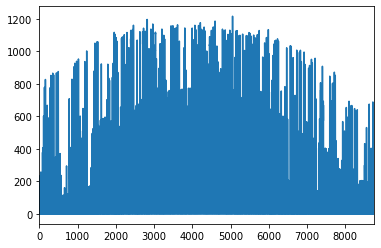

In [88]:
pd.Series(weather.total_sky_matrix.sum(axis=1)).plot()

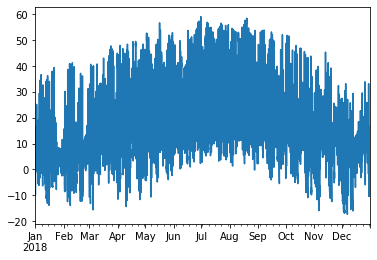

In [10]:
mean_radiant_temperature.plot()


In [66]:
sample_vector_radiation.shape

# Calculate the total radiation received on 1 square metre
A = sample_vectors_altitude[sample_vectors_is_sky]
B = np.array([i[sample_vectors_is_sky] for i in sample_vector_radiation])
C = np.sin(A) * B
ground_1m2_radiation = C.sum(axis=1)

(8760, 1000)

# MEAN RADIANT TEMPERATURE FROM WEATHERFILE!!!!!!!!!!

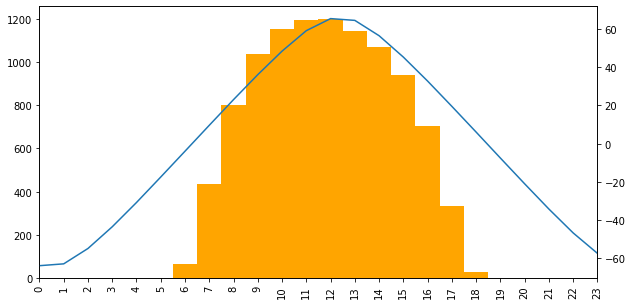

In [115]:
import matplotlib.pyplot as plt
tm = pd.Series(index=weather.index, data=weather.total_sky_matrix.sum(axis=1))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

tm.groupby([tm.index.hour]).mean().plot(ax=ax1, kind="bar", width=1, color="Orange")
weather.solar_elevation_angle.groupby([weather.index.hour]).median().plot(ax=ax2)

2018-01-29 00:00:00+04:00       0.000000
2018-01-29 01:00:00+04:00       0.000000
2018-01-29 02:00:00+04:00       0.000000
2018-01-29 03:00:00+04:00       0.000000
2018-01-29 04:00:00+04:00       0.000000
2018-01-29 05:00:00+04:00       0.000000
2018-01-29 06:00:00+04:00       0.000000
2018-01-29 07:00:00+04:00      67.398691
2018-01-29 08:00:00+04:00     143.906537
2018-01-29 09:00:00+04:00    1490.382726
2018-01-29 10:00:00+04:00    1769.603104
2018-01-29 11:00:00+04:00     384.990207
2018-01-29 12:00:00+04:00     420.256224
2018-01-29 13:00:00+04:00     391.285698
2018-01-29 14:00:00+04:00     241.114414
2018-01-29 15:00:00+04:00     196.063549
2018-01-29 16:00:00+04:00     265.392281
2018-01-29 17:00:00+04:00     144.718248
2018-01-29 18:00:00+04:00       0.000000
2018-01-29 19:00:00+04:00       0.000000
2018-01-29 20:00:00+04:00       0.000000
2018-01-29 21:00:00+04:00       0.000000
2018-01-29 22:00:00+04:00       0.000000
2018-01-29 23:00:00+04:00       0.000000
Freq: H, dtype: 

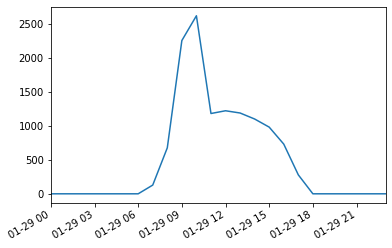

In [90]:
day = "2018-01-29"

# Diffuse matrix
dm = pd.Series(index=weather.index, data=weather.diffuse_sky_matrix.sum(axis=1))

# Direct matrix
drm = pd.Series(index=weather.index, data=weather.direct_sky_matrix.sum(axis=1))

# Total matrix
tm = pd.Series(index=weather.index, data=weather.total_sky_matrix.sum(axis=1))

tm[day].plot()
dm[day].sum() / 1000, drm[day].sum() / 1000, tm[day].sum() / 1000

dm[day]

In [67]:
pd.Series(index=weather.index, data=weather.diffuse_sky_matrix.sum(axis=1))["2018-01-29"].sum()#.plot()#.plot()

5515.111680251351

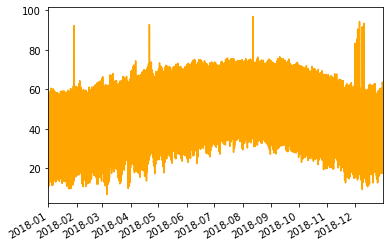

In [39]:


mean_radiant_temperature.plot(c="orange")
# mean_radiant_temperature.plot(kind="hist", bins=60)

# Define the annual method for calculation!!

# Development

In [3]:
nhour = 3183 - 1
weather.index[nhour]

Timestamp('2018-05-13 14:00:00+0000', tz='UTC', freq='60T')

In [27]:
# Pedestrian wind speed
pws = wind_speed_at_height(weather.wind_speed[nhour], h1=10, h2=2.0, rc=0.5, log=True)
# pws = 5.34834
pws

2.5013995959072965

In [28]:
gnd_temp = weather.ground_temperature_1[nhour]
dbt = weather.dry_bulb_temperature[nhour]
dpt = weather.dew_point_temperature[nhour]
rh = weather.relative_humidity[nhour]
tot_sky_cover = weather.total_sky_cover[nhour] / 10
hir = weather.horizontal_infrared_radiation_intensity[nhour]

(gnd_temp, dbt, dpt, rh, tot_sky_cover, hir)

(7.75, 11.0, 11.0, 100, 0.8, 332)

In [29]:
# Generate Numerous Vectors
weather.generate_numerous_vectors()
tsm = weather.total_sky_matrix[nhour]
vec = weather.nv_sample_vectors
alt = weather.nv_sample_thetas
sky = weather.nv_sample_sky

tsm[0:4], vec[0:4], alt[0:4], sky[0:4], 

(array([0.74866746, 0.74859408, 0.74859408, 0.7497263 ]),
 array([[ 0.04471018, -0.999     ,  0.        ],
        [-0.05707349, -0.997     ,  0.052284  ],
        [ 0.00873164, -0.995     , -0.0994925 ],
        [ 0.07186536, -0.993     ,  0.09373564]]),
 array([0.        , 0.05230785, 0.09965738, 0.09387345]),
 array([False,  True, False,  True]))

In [13]:
np.interp(np.power(weather.relative_humidity, 3), [0, 1e6], [0.33, 1.4])

array([1.19066199, 1.03459821, 1.03459821, ..., 1.03459821, 0.89864187,
       1.19066199])

In [30]:
# Surface Temperature "k"
k = np.interp(np.power(rh, 3), [0, 1e6], [0.33, 1.4])
k

1.4

In [31]:
weather.calculate_sky_emissivity()
se = weather.sky_emissivity[nhour]
se

0.8311482273571045

In [32]:
material = {'Concrete (Medium Rough)': {"D": 10.79, "E": 4.192, "F": 0}}
c_hc = material['Concrete (Medium Rough)']["D"] + material['Concrete (Medium Rough)']["E"] * pws + material['Concrete (Medium Rough)']["F"] * np.power(pws, 2)
c_hc

21.275867106043385

In [10]:
pc = weather.patch_centroids
pc[0:4]

array([[0.      , 0.997474, 0.054056],
       [0.104264, 0.99201 , 0.054056],
       [0.207387, 0.975677, 0.054056],
       [0.308237, 0.948654, 0.054056]])

In [11]:
weather.resample_sky_dome()
item = weather.nv_sample_indices
dis = weather.nv_sample_distances
item[0:3], dis[0:3]

(array([[30, 29, 31],
        [31, 30, 91],
        [30, 29, 31]]), array([[0.0701668 , 0.08073146, 0.15863233],
        [0.04748667, 0.05710296, 0.11968513],
        [0.15381647, 0.18086602, 0.19066751]]))

In [12]:
weather.calculate_sun_view_factor()
svf = weather.nv_sun_view_factor
svf[0:10]

array([0.        , 0.28872487, 0.        , 0.28932453, 0.        ,
       0.        , 0.28929047, 0.        , 0.28892727, 0.28910144])

In [13]:
weather.ray_trace_1000()
last_vector = weather.nv_last_ray_bounce_vector
len_int = weather.nv_intersected_points
last_vector[0:4], len_int[0:7], 

(array([[ 0.04471 , -0.999   ,  0.      ],
        [-0.057073, -0.997   ,  0.052284],
        [ 0.008732, -0.995   ,  0.099493],
        [ 0.071865, -0.993   ,  0.093736]]), array([0, 0, 1, 0, 1, 1, 0]))

In [14]:
# weather.closest_point(vec, last_vector[0])

from scipy import spatial
_, inds = spatial.KDTree(vec).query(last_vector, 1)
inds[0:7]

array([0, 1, 3, 3, 4, 8, 6])

In [15]:
weather.calculate_numerous_vector_radiation_values()
nvrad = weather.nv_radiation[nhour]
nvrad[0:8]
# Differences from interpretation of direct/diffuse radiaiton skly dome values - mine is better :)

array([0.        , 1.18559257, 0.        , 1.07918591, 0.        ,
       0.        , 1.14858183, 0.        ])

In [16]:
weather.m2_total_radiation()
m2rad = weather.nv_m2_radiation[nhour]
m2rad

458.08880400038174

In [17]:
weather.calculate_ein()
ein = weather.nv_ein[nhour]
ein[0:7]

array([0.        , 0.34231006, 0.31223495, 0.31223495, 0.        ,
       0.29723874, 0.33227377])

In [48]:
# Ein Out
ground_albedo = 0.2
Eout = sum(np.power(ground_albedo, len_int) * ein)
Eout

240.120035336094

In [58]:
emissivity = 0.8
absorptivity = 0.6
tickness = 0.8
# k = k
Ein = m2rad
Tin = gnd_temp
Ta = dbt
hc = c_hc

d=5.67*(10**(-8))
Tin=Tin+273.15
Ta=Ta+273.15
a=emissivity*d
b=k/tickness+hc
c=-(k*Tin/tickness+Ein*absorptivity+hc*Ta)


Ts=[]
nnn=[]
try:
    X = 1/2 *math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))-1/2*math.sqrt(-(2*b)/(a *math.sqrt((4* (2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27 *a**2 *b**4-256* a**3* c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2* b**4-256* a**3*c**3)+9*a*b**2)**(1/3))
    if 0<X:
        Ts.append(X)
except: nnn.append(1)

try:
    X = 1/2 *math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))+1/2*math.sqrt(-(2*b)/(a*math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))
    if 0<X:
        Ts.append(X)
except: nnn.append(2)

try:
    X =-1/2 *math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))-1/2*math.sqrt((2*b)/(a*math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))
    if 0<X:
        Ts.append(X)
except: nnn.append(3)

try:
    X = 1/2 *math.sqrt((2*b)/(a*math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)))-(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a)-(4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3))-1/2*math.sqrt((4*(2/3)**(1/3)*c)/(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)+(math.sqrt(3)*math.sqrt(27*a**2*b**4-256*a**3*c**3)+9*a*b**2)**(1/3)/(2**(1/3)*3**(2/3)*a))
    if 0<X:
        Ts.append(X)
except: nnn.append(4)
print(nnn)

Tsc=[]
for i in Ts:
    Tsc.append(i-273.15)
e_out=[]
for i in Ts:
    E=a*(i**4)
    e_out.append(E)

# Surface tempertaure
Ts

[1, 2]


[283.1729880630722]

In [59]:
# Atmospheric Radiation

SVF = 1
TotalSky = se * hir * SVF

TotalSky

275.9412114825587

In [60]:
# Solar Radiation

σ= 5.6697*10**(-8)
ap=0.7
if Eout:
    TotalSol=ap*Eout
else: 
    TotalSol=0
TotalSol

168.08402473526579

In [63]:
#Ground radiation

#Eurb = σ.ε.Ts**4
#Floor Fv= 0.4

A1 = 1.2  # Human area
σ= 5.6697*10**(-8)
R=[]
A2=1
for t in Ts:
    if t:
        a=(A1/A2)  *   emissivity   *   (σ*emissivity*t**4)   *    .4
        R.append(a)
SR=sum(R)
SR

111.99240865983995

In [67]:
σ= 5.6697e-8
Tmrt = np.power(((TotalSky + TotalSol + SR) / σ), 0.25) - 273.15
Tmrt

41.53940663065487